In [64]:
import db_connection as dbcon
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,linkage
import math
from encoding import target_encoding,binary_encoding
from data_imputation import impute_with_random_forest,impute_with_bayesian_ridge
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans,DBSCAN

In [3]:
db=dbcon.DBConnection()
df_source = db.get_dataframe()
df=df_source

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
df.dtypes

CodigoComponente                                 Int64
DescricaoComponente                     string[python]
QuantidadeComponente                           Float64
BitolaCaboAterramentoCarcaca [mm2]               Int64
BitolaCabosDeLigacao [mm2]                       Int64
BitolaFios01Enrol01                              Int64
CabosLigacaoEmParalelo                         boolean
CabosProtecaoTermica                    string[python]
CarcacaPlataformaEletricaRaw            string[python]
CarcacaPlataformaEletricaAlturaEixo              Int64
CarcacaPlataformaEletricaComprimento    string[python]
ChoqueTermico                                  boolean
ClassIsolamento                                boolean
CodigoDesenhoEstatorCompleto                     int64
CodigoDesenhoDiscoEstator                        int64
CodigoDesenhoDiscoRotor                 string[python]
ComprimentoExternoCabosLigacao                 Float64
DiametroAnelCurto [mm]                         Float64
DiametroEx

In [35]:
num_cols=[col for col, dtype in df.dtypes.items() if dtype != 'string[python]' and dtype != 'boolean' and dtype != 'object' ]
df[num_cols].dtypes

CodigoComponente                         Int64
QuantidadeComponente                   Float64
BitolaCaboAterramentoCarcaca [mm2]       Int64
BitolaCabosDeLigacao [mm2]               Int64
BitolaFios01Enrol01                      Int64
CarcacaPlataformaEletricaAlturaEixo      Int64
CodigoDesenhoEstatorCompleto             int64
CodigoDesenhoDiscoEstator                int64
ComprimentoExternoCabosLigacao         Float64
DiametroAnelCurto [mm]                 Float64
DiametroExternoEstator [mm]            Float64
DiametroUsinadoRotor [mm]              Float64
InclinacaoRotor [mm]                   Float64
LarguraAnelCurto [mm]                  Float64
NrTotalFiosEnrol                         Int64
ComprimentoTotalPacote [mm]            Float64
PolaridadeCompleta                       Int64
PotenciaCompletaCv01                   float64
QuantidadeCabosProtetorTermico01         Int64
QuantidadeDeCabosDeLigacao               Int64
QuantidadeTotalProtecaoTermica           Int64
CustoIndustri

In [40]:
df_bin=impute_with_bayesian_ridge(binary_encoding(df))
df_tgt=impute_with_bayesian_ridge(target_encoding(df))

In [61]:
df_tgt_br=impute_with_bayesian_ridge(target_encoding(df))

In [ ]:
df_tgt_rf=impute_with_random_forest(target_encoding(df))

In [5]:
print(df_bin.shape,df_tgt.shape)

(9261, 100) (9261, 51)


# Bayesian Ridge Imputation

In [62]:
data_br = df_tgt_br.drop('CustoIndustrial', axis=1).values

## Hierarquical Clustering

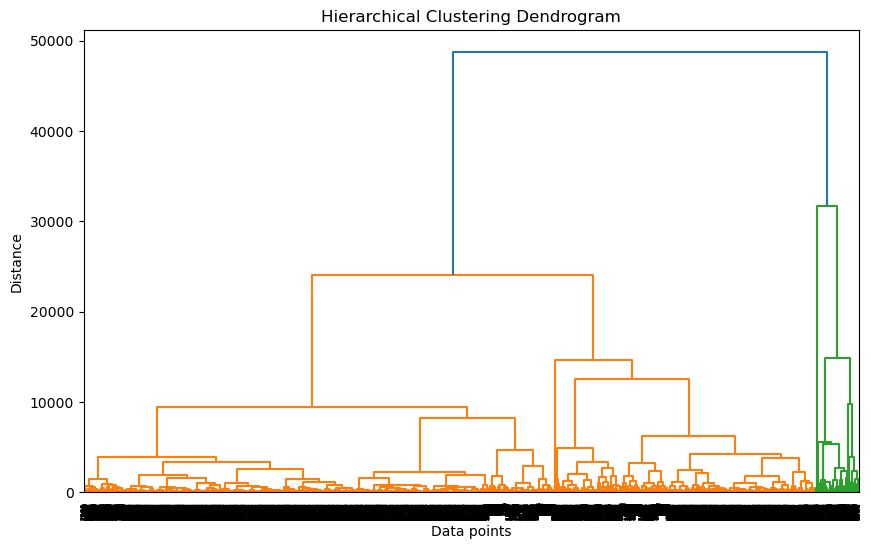

In [43]:
distance_matrix = linkage(data_br, method='ward')

# Create a dendrogram
plt.figure(figsize=(10, 6))
dendrogram(distance_matrix)
plt.xlabel("Data points")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [44]:

# Define the number of clusters (adjust as needed)
num_clusters = 2

# Get cluster labels for each data point
cluster_labels = fcluster(distance_matrix, num_clusters, criterion='maxclust')

# **Corrected Line:** Add cluster labels as a separate column (avoid modifying df)
df_with_clusters = df_tgt.copy()  # Create a copy to avoid modifying original df
df_with_clusters['cluster'] = cluster_labels


# Print data points with their corresponding clusters

for col in num_cols:
    print(f"--- Feature: {col} ---",'\n')
    print(df_with_clusters.groupby('cluster')[col].describe(),'\n\n')

--- Feature: CodigoComponente --- 

          count      mean       std       min       25%       50%       75%  \
cluster                                                                       
1        8755.0  0.154862  0.018541  0.044373  0.156428  0.157911  0.158440   
2         506.0  0.159373  0.019459  0.046924  0.156428  0.158182  0.160373   

              max  
cluster            
1        0.214343  
2        0.214343   


--- Feature: QuantidadeComponente --- 

          count       mean        std    min     25%     50%      75%      max
cluster                                                                       
1        8755.0  52.549006  42.927163  1.555  22.070  43.384  70.1095  519.148
2         506.0  45.067055  40.216859  1.000  18.462  33.564  61.0910  284.023 


--- Feature: BitolaCaboAterramentoCarcaca [mm2] --- 

          count       mean        std   min   25%   50%   75%    max
cluster                                                             
1        8755

In [52]:
df_with_clusters.groupby('cluster')['CustoIndustrial'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,8755.0,0.154490,0.097728,0.03798,0.084840,0.13159,0.191675,1.00000
2,506.0,0.165413,0.115063,0.04688,0.087648,0.13615,0.193752,0.88344


In [59]:
cluster1_data = df_with_clusters[df_with_clusters['cluster'] == 1]
cluster2_data = df_with_clusters[df_with_clusters['cluster'] == 2]

# Assuming feature1 is the feature you want to compare
tstatistic, pvalue = ttest_ind(cluster1_data['CustoIndustrial'], cluster2_data['CustoIndustrial'])

print(f'tstatistic = {tstatistic}', '\n', f'pvalue = {pvalue}')

tstatistic = -2.4190544695500704 
 pvalue = 0.015580059249847653


## Kmeans

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster labels: [0 0 0 ... 0 0 0]
Centroids: [[1.54819224e-01 1.54819224e-01 5.25371421e+01 4.73401901e+01
  3.71500000e+01 1.31875457e+03 1.49543379e-02 1.54327328e-01
  1.55691418e-01 2.95408676e+02 1.55498569e-01 8.51261908e-01
  1.02397260e-01 1.55135049e-01 1.55528529e-01 1.55842148e-01
  3.48173516e-01 5.39164976e+01 4.87806931e+02 3.17601697e+02
  1.53089165e-01 1.55667735e-01 1.74831416e+01 3.42160052e+01
  1.54725466e-01 1.55050370e-01 1.54763876e-01 5.82191781e-03
  1.26122874e+01 3.48261986e+02 1.55023405e-01 3.96210046e+00
  1.98517812e+02 3.56746575e+00 5.97054795e+00 1.16198630e+00
  1.55244052e-01 9.47831050e-01 1.51794636e-01 4.05479452e-01
  3.88127854e-03 4.04038197e+00 4.04837896e+00 4.06165558e+00
  4.04847256e+00 9.73458114e-02 6.30140326e+01 6.77017922e+01
  7.84768785e+01 6.77565881e+01 6.85135695e+00]
 [1.59199410e-01 1.59199410e-01 4.51998323e+01 4.26774776e+01
  3.46826347e+01 1.31636727e+03 3.79241517e-02 1.68373195e-01
  1.37202154e-01 2.85528942e+02 1.39407

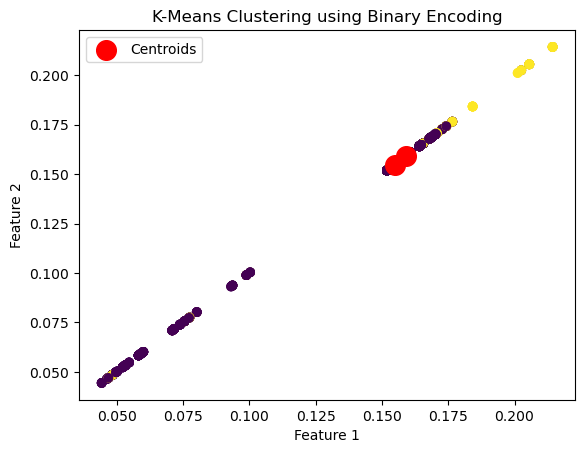

In [68]:
# Define the number of clusters (experiment with different values)
k = 2

# Create the K-Means object
kmeans = KMeans(n_clusters=k, random_state=0)  # Set random_state for reproducibility

# Fit the model to the data
kmeans.fit(data_br)

# Get cluster labels
cluster_labels = kmeans.labels_

# Get centroids (cluster centers)
centroids = kmeans.cluster_centers_

# Print results
print("Cluster labels:", cluster_labels)
print("Centroids:", centroids)

plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=200, c='red', label='Centroids')
plt.title("K-Means Clustering using Binary Encoding")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [73]:
# **Corrected Line:** Add cluster labels as a separate column (avoid modifying df)
df_kmeans = df_tgt_br.copy()  # Create a copy to avoid modifying original df
df_kmeans['cluster'] = kmeans.labels_

# Print data points with their corresponding clusters

for col in num_cols:
    print(f"--- Feature: {col} ---",'\n')
    print(df_kmeans.groupby('cluster')[col].describe(),'\n\n')

--- Feature: CodigoComponente --- 

          count      mean       std       min       25%       50%       75%  \
cluster                                                                       
0        8760.0  0.154819  0.018520  0.042514  0.157215  0.157483  0.158206   
1         501.0  0.159199  0.019249  0.046634  0.157215  0.157679  0.158206   

              max  
cluster            
0        0.206701  
1        0.206701   


--- Feature: QuantidadeComponente --- 

          count       mean        std    min     25%     50%       75%  \
cluster                                                                  
0        8760.0  52.537142  42.919125  1.555  22.070  43.383  70.10075   
1         501.0  45.199832  40.370309  1.000  18.457  33.717  61.43900   

             max  
cluster           
0        519.148  
1        284.023   


--- Feature: BitolaCaboAterramentoCarcaca [mm2] --- 

          count       mean        std   min   25%   50%   75%    max
cluster                  

In [70]:
df_kmeans.groupby('cluster')['CustoIndustrial'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,8760.0,0.154453,0.097714,0.03798,0.084825,0.13158,0.191603,1.00000
1,501.0,0.166167,0.115363,0.04688,0.087850,0.13637,0.194040,0.88344


In [76]:
cluster1_data = df_kmeans[df_kmeans['cluster'] == 0]
cluster2_data = df_kmeans[df_kmeans['cluster'] == 1]

# Assuming feature1 is the feature you want to compare
tstatistic, pvalue = ttest_ind(cluster1_data['CustoIndustrial'], cluster2_data['CustoIndustrial'])

print(f'tstatistic = {tstatistic}', '\n', f'pvalue = {pvalue}')

tstatistic = -2.582242645146659 
 pvalue = 0.00983126671478138


# Random Forest Imputation

# Test with Binary Encoding

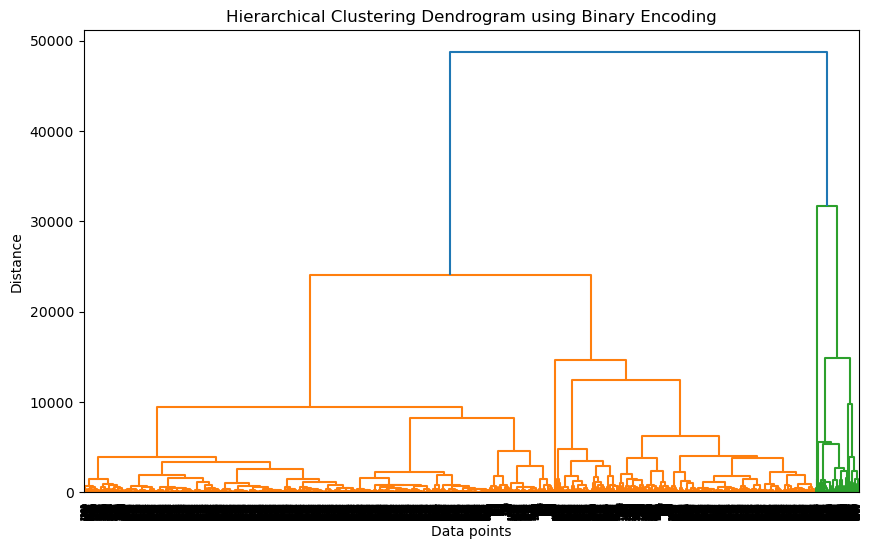

In [48]:
data_bin = df_bin.drop('CustoIndustrial', axis=1).values

distance_matrix_bin = linkage(data_bin, method='ward')

# Create a dendrogram
plt.figure(figsize=(10, 6))
dendrogram(distance_matrix_bin)
plt.xlabel("Data points")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram using Binary Encoding")
plt.show()

In [55]:
df_with_clusters_bin.groupby('cluster')['CustoIndustrial'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,8755.0,0.154490,0.097728,0.03798,0.084840,0.13159,0.191675,1.00000
2,506.0,0.165413,0.115063,0.04688,0.087648,0.13615,0.193752,0.88344
